In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
    
aequ_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
if aequ_dir not in sys.path:
    sys.path.append(aequ_dir)

from aequilibrae import logger  # noqa: E402
stdout_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_handler)

import utils


from aequilibrae.paths import TrafficAssignment  # noqa: E402
from aequilibrae.paths import Graph  # noqa: E402
from aequilibrae.paths.traffic_class import TrafficClass  # noqa: E402
from aequilibrae.matrix import AequilibraeMatrix, AequilibraeData  # noqa: E402
from aequilibrae.paths.path_based import TrafficAssignmentCy

In [4]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")
scenario = "Anaheim" #"Berlin-Center" #
folder = os.path.join(tntp_dir, scenario)

if scenario == "Anaheim":
    link_file =  "Anaheim_net.tntp"
    trip_file =  "Anaheim_trips.tntp"
elif scenario == "Berlin-Center":
    link_file =  "berlin-center_net_clean.tntp" # DUPLICATE NODES REMOVED  "berlin-center_net_clean_bpr_altered.tntp" #
    trip_file =  "berlin-center_trips.tntp"
else:
    raise ValueError(f"Unknown scenario {scenario}")

In [5]:
%%time
assig = utils.set_up_assignment(tntp_dir, scenario, link_file, "bush-based", block_centroids=False, rgap=5*1e-5)

assig.assignment.initialise_data_structures()
num_links = len(assig.assignment.links)
num_nodes = len(assig.assignment.nodes)
num_centroids = len(assig.assignment.origins)
logger.info(f" Initialised data structures, num nodes = {num_nodes}, num links = {num_links}")
assig.assignment.t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(assig.assignment.links, num_links, num_nodes, num_centroids)
destinations_per_origin = {}
for (o, d) in assig.assignment.ods:
    assig.assignment.t_assignment.insert_od(o, d, assig.assignment.ods[o, d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

assig.assignment.t_assignment.perform_initial_solution()
logger.info(f" 0th iteration done, cost = {assig.assignment.t_assignment.get_objective_function()}")

 Initialised data structures, num nodes = 416, num links = 914
 0th iteration done, cost = 1264524.25
CPU times: user 172 ms, sys: 62.5 ms, total: 234 ms
Wall time: 228 ms


In [26]:
%%time
assig = utils.set_up_assignment(tntp_dir, scenario, link_file, "bush-based", block_centroids=False, rgap=5*1e-5)

assig.assignment.initialise_data_structures()
num_links = len(assig.assignment.links)
num_nodes = len(assig.assignment.nodes)
num_centroids = len(assig.assignment.origins)
logger.info(f" Initialised data structures, num nodes = {num_nodes}, num links = {num_links}")
assig.assignment.t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(assig.assignment.links, num_links, num_nodes, num_centroids)
destinations_per_origin = {}
for (o, d) in assig.assignment.ods:
    assig.assignment.t_assignment.insert_od(o, d, assig.assignment.ods[o, d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

assig.assignment.initial_iteration()
logger.info(f" 0th iteration done, cost = {assig.assignment.t_assignment.get_objective_function()}")

 Initialised data structures, num nodes = 416, num links = 914
 0th iteration done, cost = 1264523.25
CPU times: user 500 ms, sys: 78.1 ms, total: 578 ms
Wall time: 299 ms


In [27]:
sol_ = pd.DataFrame(assig.classes[0].graph.network)
sol_["flow"] = assig.assignment.t_assignment.get_link_flows()
sol_['flow_1'] = assig.assignment.total_flow

In [28]:
sol_

,link_id,a_node,b_node,time,capacity,alpha,beta,direction,flow,flow_1
0,0,1,117,1.090458,9000,0.15,4,1,7074.900879,7074.900879
1,1,2,87,1.090458,9000,0.15,4,1,9662.499023,9662.499023
2,2,3,74,1.090458,9000,0.15,4,1,7669.000977,7669.000977
3,3,4,233,1.090458,9000,0.15,4,1,12173.798828,12173.798828
4,4,5,165,1.090458,9000,0.15,4,1,2586.800537,2586.800537
...,...,...,...,...,...,...,...,...,...,...
909,909,414,405,2.000000,5400,0.15,4,1,375.100006,375.100006
910,910,415,22,1.000000,5400,0.15,4,1,1196.199829,1196.199829
911,911,415,406,2.000000,5400,0.15,4,1,1149.299927,1149.299927
912,912,416,23,1.000000,5400,0.15,4,1,387.899933,387.899933


In [12]:
%%time
assig = utils.set_up_assignment(tntp_dir, scenario, link_file, "bush-based", block_centroids=False, rgap=5*1e-5)
assig.execute()

# the results are within each traffic class only one, in this case
# assigclass.results.link_loads
sol_ = pd.DataFrame(assig.classes[0].graph.network)
sol_["flow"] = assig.classes[0].results.link_loads

bush-based Assignment STATS
 Initialised data structures, num nodes = 416, num links = 914
 0th iteration done, cost = 1264523.25
Iteration 1, computed gap: 0.004901110269258657, computed objective: 1240970.875
Iteration 2, computed gap: 0.00031101824531987177, computed objective: 1237496.0
Iteration 3, computed gap: 0.00019335951607357682, computed objective: 1237246.75
Iteration 4, computed gap: 0.0001374119609521829, computed objective: 1237182.125
Iteration 5, computed gap: 3.0923055711395975e-05, computed objective: 1237167.75
bush-based Assignment finished. 5 iterations and 3.0923055711395975e-05 final gap
CPU times: user 56.7 s, sys: 7.78 s, total: 1min 4s
Wall time: 9.17 s


In [28]:
#assig.assignment.total_flow

In [51]:
%%time
path_res_ = utils.get_assignment_solution(tntp_dir, scenario, link_file, method="bush-based", block_centroids=True, rgap=1*1e-5)

bush-based Assignment STATS
 Initialised data structures, num nodes = 416, num links = 914
 0th iteration done, cost = 1296185.75
Iteration 1, computed gap: 0.0020655976391339426, computed objective: 1287869.375
Iteration 2, computed gap: 0.00010550308297574418, computed objective: 1286209.75
Iteration 3, computed gap: 1.4592302448046546e-05, computed objective: 1286160.125
bush-based Assignment finished. 3 iterations and 1.4592302448046546e-05 final gap
CPU times: user 33.3 s, sys: 5.2 s, total: 38.5 s
Wall time: 5.25 s


In [52]:
%%time
bfw_res_ = utils.get_assignment_solution(tntp_dir, scenario, link_file, method="bfw", block_centroids=True, rgap=1*1e-5)

bfw Assignment STATS
Iteration, RelativeGap, stepsize
1,inf,1.0
2,0.01813536336911382,0.2561015932062776
# Alert: Adding 0.3333333333333333 to stepsize to make it non-zero
3,0.0036265961074987314,0.3333333333333333
# Alert: Adding 0.25 to stepsize to make it non-zero
4,0.002300502121447229,0.25
# Alert: Adding 0.2 to stepsize to make it non-zero
5,0.0016660925434689557,0.2
# Alert: Adding 0.16666666666666666 to stepsize to make it non-zero
6,0.0013674148395812515,0.16666666666666666
# Alert: Adding 0.14285714285714285 to stepsize to make it non-zero
7,0.001152166503599817,0.14285714285714285
# Alert: Adding 0.125 to stepsize to make it non-zero
8,0.0009970861455201863,0.125
# Alert: Adding 0.1111111111111111 to stepsize to make it non-zero
9,0.0008651833121821925,0.1111111111111111
# Alert: Adding 0.1 to stepsize to make it non-zero
10,0.0007703386571853957,0.1
# Alert: Adding 0.09090909090909091 to stepsize to make it non-zero
11,0.0007020823903876606,0.09090909090909091
# Alert: Addi

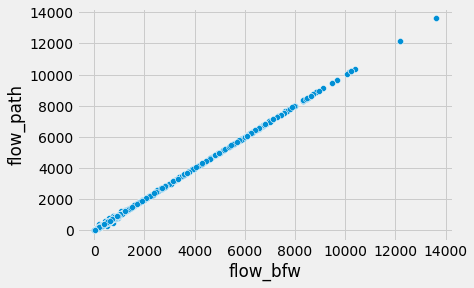

max diff in flow = 250.174
max rel diff in flow = 9241.480%


,link_id_bfw,a_node,b_node,capacity_bfw,alpha_bfw,beta_bfw,direction_bfw,flow_bfw,link_id_path,capacity_path,alpha_path,beta_path,direction_path,flow_path,abs_change,rel_change
607,607,327,328,5400,0.15,4,1,750.660952,607,5400,0.15,4,1,500.487152,250.173800,0.333271
663,663,341,342,5400,0.15,4,1,614.924917,663,5400,0.15,4,1,811.013000,196.088084,0.318881
605,605,327,315,5400,0.15,4,1,736.201772,605,5400,0.15,4,1,930.213257,194.011484,0.263530
564,564,315,299,5400,0.15,4,1,736.201772,564,5400,0.15,4,1,930.213257,194.011484,0.263530
509,509,299,300,5400,0.15,4,1,208.359120,509,5400,0.15,4,1,393.525116,185.165996,0.888687
568,568,316,300,5400,0.15,4,1,497.622885,568,5400,0.15,4,1,312.499969,185.122916,0.372014
609,609,328,316,5400,0.15,4,1,969.220878,609,5400,0.15,4,1,784.100037,185.120842,0.191000
698,698,353,341,5400,0.15,4,1,1086.649536,698,5400,0.15,4,1,1266.013306,179.363770,0.165061
667,667,342,343,5400,0.15,4,1,434.688057,667,5400,0.15,4,1,593.534729,158.846672,0.365427
700,700,353,354,5400,0.15,4,1,609.619813,700,5400,0.15,4,1,455.193481,154.426331,0.253316


In [53]:
full_result = bfw_res_.drop(columns=['time']).merge(path_res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
sns.scatterplot(data=full_result, x='flow_bfw', y='flow_path');
plt.show();
full_result['abs_change'] = np.abs(full_result.flow_bfw - full_result.flow_path)
full_result['rel_change'] = full_result['abs_change'] / full_result['flow_bfw']
print(f"max diff in flow = {full_result['abs_change'].max():.3f}")
print(f"max rel diff in flow = {full_result['rel_change'].abs().max():.3f}%")
display(full_result.sort_values(by=['abs_change'], ascending=False).head(10))

# tests, etc

In [37]:
%%time
assig = utils.set_up_assignment(tntp_dir, scenario, link_file, "bush-based", block_centroids=False, rgap=5*1e-5)

assig.assignment.initialise_data_structures()
num_links = len(assig.assignment.links)
num_nodes = len(assig.assignment.nodes)
num_centroids = len(assig.assignment.origins)
logger.info(f" Initialised data structures, num nodes = {num_nodes}, num links = {num_links}")
assig.assignment.t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(assig.assignment.links, num_links, num_nodes, num_centroids)
destinations_per_origin = {}
for (o, d) in assig.assignment.ods:
    assig.assignment.t_assignment.insert_od(o, d, assig.assignment.ods[o, d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

 Initialised data structures, num nodes = 416, num links = 914
CPU times: user 141 ms, sys: 93.8 ms, total: 234 ms
Wall time: 224 ms


In [38]:
test_o = 12
assig.assignment.t_assignment.compute_shortest_paths(test_o)
precedence = assig.assignment.t_assignment.get_precedence()

In [39]:
test_d = 10
next_iter = test_d
nodes = []
while(next_iter != test_o):
    nodes.append(next_iter)
    next_iter = precedence[next_iter]
nodes.append(next_iter) # if we want the origin node in there
print(nodes)

[10, 308, 307, 294, 293, 292, 273, 25, 272, 261, 12]


In [40]:
from aequilibrae.paths.multi_threaded_aon import MultiThreadedAoN
from aequilibrae.paths.AoN import one_to_all

assig = utils.set_up_assignment(tntp_dir, scenario, link_file, "bush-based", block_centroids=True, rgap=5*1e-5)

assig.assignment.initialise_data_structures()
num_links = len(assig.assignment.links)
num_nodes = len(assig.assignment.nodes)
num_centroids = len(assig.assignment.origins)
logger.info(f" Initialised data structures, num nodes = {num_nodes}, num links = {num_links}")
assig.assignment.t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(assig.assignment.links, num_links, num_nodes, num_centroids)
destinations_per_origin = {}
for (o, d) in assig.assignment.ods:
    assig.assignment.t_assignment.insert_od(o, d, assig.assignment.ods[o, d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

c = assig.assignment.traffic_classes[0]

matrix = c.matrix
graph = c.graph
results = c._aon_results
aux_res = MultiThreadedAoN()

aux_res.prepare(graph, results)
matrix.matrix_view = c.matrix.matrix_view.reshape(
    (graph.num_zones, graph.num_zones, results.classes["number"])
)

th = 0 # th is thread id
origin = test_o + 1 # sort out this mess
x = one_to_all(origin, matrix, graph, results, aux_res, th)

# set precedence to aux_res.predecessors[:,0]

 Initialised data structures, num nodes = 416, num links = 914


In [41]:
aux_res.predecessors[:,0]

array([ 87,  61,  74, 233, 117, 165, 213, 410, 378, 337, 308, 274,  -1,
       256, 253, 262, 275, 321, 363, 396, 411, 414, 415, 266, 268, 272,
       302, 303, 307, 339, 329, 332, 336, 368, 372, 377, 400, 406, 266,
       268, 272, 302, 303, 307, 339, 329, 332, 336, 368, 372, 377, 400,
       406,  56, 237,  53, 146,  -1, 102, 137, 102,  62, 189,  64,  65,
       259,  67, 257,  69, 254,  71, 141,  -1,  -1,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84, 189,  -1,  -1,  88,  89,  90,  91,
       183,  93, 289,  95, 287,  97, 282,  99, 277, 101,  55, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 183, 113, 114, 293,  -1,  -1,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135,  60, 137, 138, 139, 140,  76, 142, 143,
       144, 145,  58, 147, 296, 149, 150, 309, 152, 322, 154, 155, 348,
       157, 364, 159, 380, 161, 162, 398,  -1,  -1, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [42]:
precedence

array('i', [87, 61, 74, 233, 117, 165, 213, 410, 378, 337, 308, 274, 12, 256, 253, 262, 275, 321, 363, 396, 412, 414, 415, 266, 268, 272, 302, 303, 307, 340, 329, 332, 336, 368, 372, 377, 400, 406, 266, 268, 272, 302, 303, 307, 340, 329, 332, 336, 368, 372, 377, 400, 406, 56, 237, 53, 146, 231, 102, 137, 102, 62, 189, 64, 65, 259, 67, 257, 69, 254, 71, 141, 73, 2, 75, 76, 77, 255, 79, 258, 81, 82, 83, 84, 189, 86, 1, 88, 292, 90, 91, 183, 93, 289, 95, 287, 97, 282, 99, 277, 101, 59, 103, 104, 105, 106, 107, 108, 109, 110, 111, 183, 113, 114, 293, 116, 0, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 264, 140, 76, 142, 263, 144, 145, 58, 147, 296, 149, 150, 309, 152, 322, 154, 155, 348, 157, 364, 159, 380, 161, 162, 398, 164, 4, 166, 167, 168, 169, 392, 171, 172, 173, 174, 175, 359, 177, 335, 179, 180, 181, 182, 183, 184, 185, 271, 187, 188, 63, 190, 191, 270, 193, 194, 112, 196, 197, 305, 199, 334, 201, 358, 203, 375, 205, 206,

In [43]:
# so at position test_o, precedence contains test_o, but aux_res.precedence contains -1. in c++ the origin node itself is never used, so should work one-to-one
precedence == aux_res.predecessors[:,0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [5]:
%%time
path_res_ = utils.get_assignment_solution(tntp_dir, scenario, link_file, method="bush-based", block_centroids=False, rgap=5*1e-5)

bush-based Assignment STATS
 Initialised data structures, num nodes = 12981, num links = 28370
 0th iteration done, cost = 17175346.0
Iteration 1, computed gap: 0.03523369394561715, computed objective: 13572901.0
Iteration 2, computed gap: 0.008124234031658073, computed objective: 13446520.0
Iteration 3, computed gap: 0.0018462100719774943, computed objective: 13425886.0
Iteration 4, computed gap: 0.0005136246907306852, computed objective: 13421236.0
Iteration 5, computed gap: 0.00017223551787159952, computed objective: 13420094.0
Iteration 6, computed gap: 7.091238174428138e-05, computed objective: 13419739.0
bush-based Assignment finished. 6 iterations and 7.091238174428138e-05 final gap
CPU times: user 19min 51s, sys: 13min 37s, total: 33min 29s
Wall time: 4min 54s


In [6]:
%%time
bfw_res_ = utils.get_assignment_solution(tntp_dir, scenario, link_file, method="bfw", block_centroids=False, rgap=5*1e-5)

bfw Assignment STATS
Iteration, RelativeGap, stepsize
1,inf,1.0
2,0.3800567793701656,0.5300666634760473
3,0.02995166794864988,0.4419368001798535
4,0.011215453493207569,0.9740669340921474
5,0.018651911495302792,0.207438236660486
6,0.005588851085212455,0.23649241559763462
7,0.0034952930085653255,0.6993747625312287
8,0.006823974042287565,0.14055669550649857
9,0.0024604856164390475,0.15286896543449707
10,0.002205272541373415,0.293308282199271
11,0.0021288156703840886,0.6046893730021614
12,0.002492468003123535,0.07319402743157027
13,0.00131718613100849,0.08685959866044622
14,0.0009672259824663231,0.11058853630707233
15,0.001022491311937068,0.2883890249916652
16,0.0010965872573139763,0.38329827219457985
17,0.0010136654495672723,0.8179597775527969
18,0.0011814305462246335,0.041757769616305375
19,0.0006496400262115819,0.05098914445432661
20,0.0005304649833509292,0.12421073186907841
21,0.0006185390637040683,0.1536965273896091
22,0.0005388025513493729,0.18786483242656604
23,0.0004177885118343967

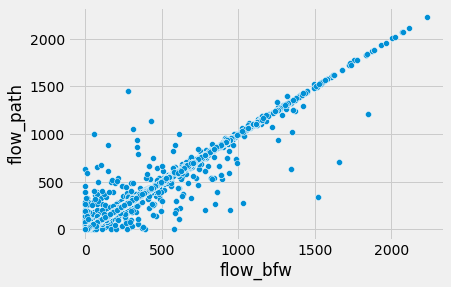

max diff in flow = 1177.696
max rel diff in flow = inf%


,link_id_bfw,a_node,b_node,capacity_bfw,alpha_bfw,beta_bfw,direction_bfw,flow_bfw,link_id_path,capacity_path,alpha_path,beta_path,direction_path,flow_path,abs_change,rel_change
2092,2092,419,8720,999999.0,0.0,4.0,1,279.816726,2092,999999.0,0.0,4.0,1,1457.512451,1177.695725,4.208811
19490,19490,8720,413,999999.0,0.0,4.0,1,279.816726,19490,999999.0,0.0,4.0,1,1457.512451,1177.695725,4.208811
18848,18848,8426,413,999999.0,0.0,4.0,1,1520.377608,18848,999999.0,0.0,4.0,1,343.900146,1176.477461,0.773806
2090,2090,419,8426,999999.0,0.0,4.0,1,1520.377608,2090,999999.0,0.0,4.0,1,343.900146,1176.477461,0.773806
2060,2060,413,8426,999999.0,0.0,4.0,1,1660.650390,2060,999999.0,0.0,4.0,1,710.855652,949.794738,0.571941
18849,18849,8426,419,999999.0,0.0,4.0,1,1660.650390,18849,999999.0,0.0,4.0,1,710.855652,949.794738,0.571941
19491,19491,8720,419,999999.0,0.0,4.0,1,54.129914,19491,999999.0,0.0,4.0,1,1002.452454,948.322540,17.519380
2061,2061,413,8720,999999.0,0.0,4.0,1,54.129914,2061,999999.0,0.0,4.0,1,1002.452454,948.322540,17.519380
418,418,84,10750,999999.0,0.0,4.0,1,1028.536830,418,999999.0,0.0,4.0,1,281.382904,747.153926,0.726424
22833,22833,10321,84,999999.0,0.0,4.0,1,946.651861,22833,999999.0,0.0,4.0,1,199.497955,747.153906,0.789259


In [8]:
full_result = bfw_res_.drop(columns=['time']).merge(path_res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
sns.scatterplot(data=full_result, x='flow_bfw', y='flow_path');
plt.show();
full_result['abs_change'] = np.abs(full_result.flow_bfw - full_result.flow_path)
full_result['rel_change'] = full_result['abs_change'] / full_result['flow_bfw']
print(f"max diff in flow = {full_result['abs_change'].max():.3f}")
print(f"max rel diff in flow = {full_result['rel_change'].abs().max():.3f}%")
display(full_result.sort_values(by=['abs_change'], ascending=False).head(10))